<a href="https://colab.research.google.com/github/AleksandrSosnin/Home_Work_A-B-test/blob/main/5_6_M5_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://mailfit.com/wp-content/uploads/2019/11/lego-5.png"  width=900></p>
<h1 style="text-align: center;"><b>«Домашняя работа» - Множественное тестирование</b></h3>


## Импорт библиотек

In [10]:
import numpy as np
import pandas as pd

import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from scipy.stats import f_oneway

## Импорт данных

In [2]:
data_path = "https://raw.githubusercontent.com/a-milenkin/mipt_data_science_2021/main/data/people_data_clustering.csv"
data = pd.read_csv(data_path, index_col=0)
print("Размеры датасета", data.shape)
data.head(6)

Размеры датасета (6000, 9)


,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
id,,,,,,,,,
0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579
5,1,3.0,2.474979e+06,0,21.0,Homemaker,1.001654e+07,1.0,0.326801


<div class="alert alert-info">
<b>Про Датасет</b>
    
Датасет представляет собой информацию по жителям некоторого города.

* `was_married` - Был ли когда-либо женат/замужем
* `children` - Количество детей
* `salary` - Уровень зарплаты
* `sex` - Пол (0 - женщина, 1 - мужчина)
* `age` - Возраст
* `home_cost` - Сумарная стоимость жилья/недвижимости
* `Professon` - Профессия
* `drive_info` - Есть ли водительские права
* `happyness` - уровень счастья по результатам опроса
    
</div>

<div class="alert alert-info">
<b>Задание</b>

Изучить датасет, выполнить задания и проверить некоторые гипотезы, предложенные ниже, опираясь уже **НЕ** только на визуализацию. Само задание выполнить на языке **Python**.
   

# Чистка датасета
* Есть ли дубли в данных? Если есть - удалить (drop_duplicates).
* Есть ли пропуски в данных? Если есть - удалить столбцы, в которых они есть. (dropna())
* Найти и удалить/отфильтровать выбросы по признаку `home_cost`. Сколько их?

In [4]:
duplicates = data .duplicated().sum()
df = data.drop_duplicates()
print(f'Количество дубликатов, найденных и удаленных: {duplicates}')

Количество дубликатов, найденных и удаленных: 0


In [5]:
# 2. Проверка на пропуски и удаление столбцов с пропусками
missing_data = data.isnull().sum()
columns_with_na = missing_data[missing_data > 0].index.tolist()
data_cleaned = data.dropna(axis=1)
print(f'Удалены следующие столбцы с пропусками: {columns_with_na}')

Удалены следующие столбцы с пропусками: ['drive_info']


In [6]:
# 3. Поиск и удаление выбросов по признаку home_cost
# Предположим, что выбросы будем определять как значения, которые выходят за пределы 1.5 IQR

Q1 = data_cleaned['home_cost'].quantile(0.25)
Q3 = data_cleaned['home_cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data_cleaned[(data_cleaned['home_cost'] < lower_bound) | (data_cleaned['home_cost'] > upper_bound)]
data_cleaned = data_cleaned[(data_cleaned['home_cost'] >= lower_bound) & (data_cleaned['home_cost'] <= upper_bound)]

print(f'Количество выбросов по признаку home_cost: {outliers.shape[0]}')

Количество выбросов по признаку home_cost: 13


# Проверка гипотез

# Изучение датасета
* Какие признаки численные?
* Какие признаки категориальные?
* Какие признаки имеют нормальное распределение?
* Какие признаки бессмысленные?

<div class="alert alert-info">

<b>Задание:</b>    
    
Перед вами уже знакомый датасет, который был дан в прошлых домашних заданиях. Вы уже научились применить подходящий статистический критерий для двух групп, теперь вам предстоит научиться верно применять критерии для нескольких групп одновременно.
    

<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Homemaker**, **Marketing**, **Healthcare** и **Executive** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием.

In [7]:
# Фильтрация данных по нужным профессиям
professions_of_interest = ['Homemaker', 'Marketing', 'Healthcare', 'Executive']
filtered_data = data[data['profession'].isin(professions_of_interest)]

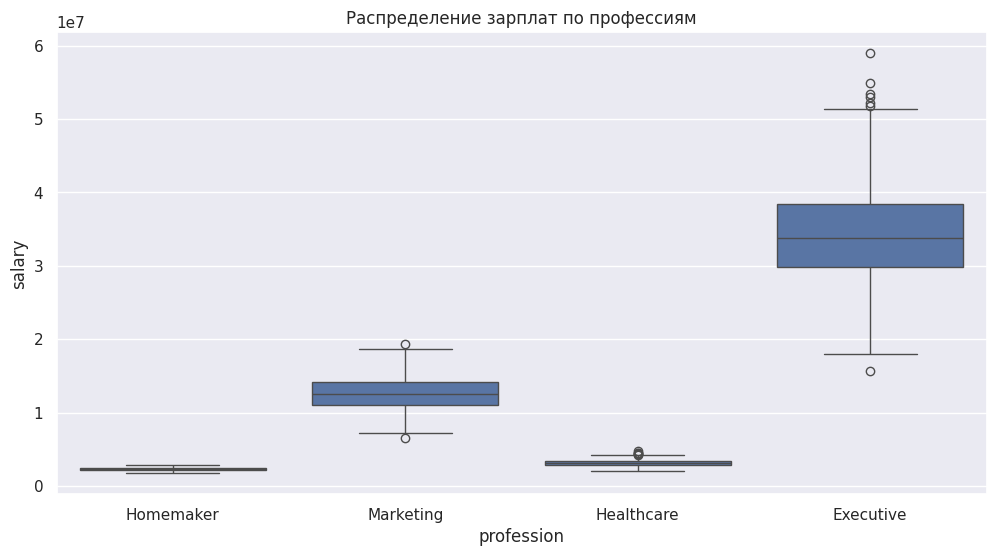

In [8]:
# Визуализация зарплат по профессиям
plt.figure(figsize=(12, 6))
sns.boxplot(x='profession', y='salary', data=filtered_data)
plt.title('Распределение зарплат по профессиям')
plt.show()

In [11]:
# Применение ANOVA
groups = [filtered_data[filtered_data['profession'] == profession]['salary']
          for profession in professions_of_interest]

f_statistic, p_value = f_oneway(*groups)

In [12]:
# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Средние зарплаты между профессиями значительно отличаются.")
else:
    print("Средние зарплаты между профессиями не отличаются.")

Средние зарплаты между профессиями значительно отличаются.


<div class="alert alert-warning">
    
* Правда ли между представителями таких профессий как, **Doctor**, **Entertainment** и **Lawyer** в среднем  зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием.

In [13]:
 # Фильтрация данных по нужным профессиям
professions_of_interest = ['Doctor', 'Entertainment', 'Lawyer']
filtered_data = data[data['profession'].isin(professions_of_interest)]

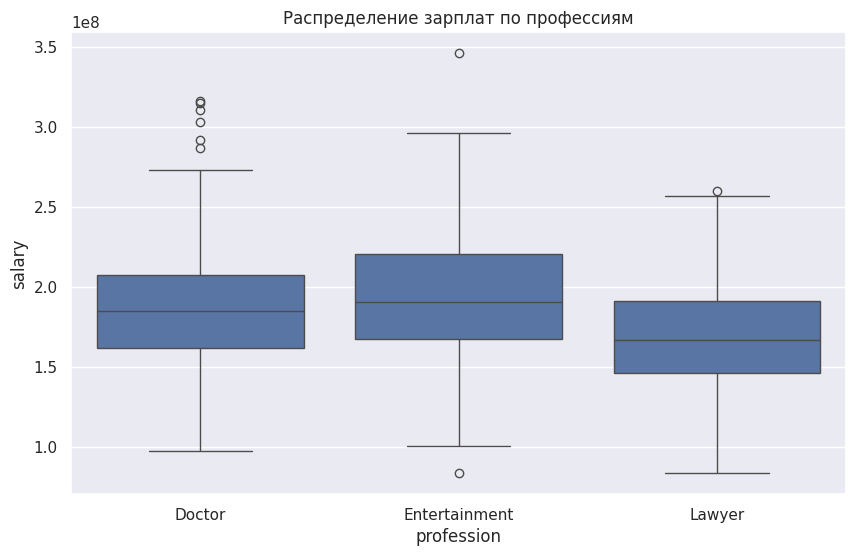

In [14]:
# Визуализация зарплат по профессиям
plt.figure(figsize=(10, 6))
sns.boxplot(x='profession', y='salary', data=filtered_data)
plt.title('Распределение зарплат по профессиям')
plt.show()

In [15]:
# Применение ANOVA
groups = [filtered_data[filtered_data['profession'] == profession]['salary']
          for profession in professions_of_interest]

f_statistic, p_value = f_oneway(*groups)

print(f'F-статистика: {f_statistic}')
print(f'p-значение: {p_value}')

F-статистика: 89.56052385242255
p-значение: 5.67666591800931e-38


In [16]:
# Интерпретация результатов
alpha = 0.05
if p_value < alpha:
    print("Средние зарплаты между профессиями значительно отличаются.")
else:
    print("Средние зарплаты между профессиями не отличаются.")

Средние зарплаты между профессиями значительно отличаются.


<div class="alert alert-warning">
    
Допустим вы рассматриваете 4 группы населения, отличающихся количеством  детей. Группы следующие.
* **A** - нет детей
* **B** - 1 ребенок
* **C** - от 2 до 4 детей
* **D** - от 5 детей    
    
    
* Правда ли, что эти группы отличаются статистически значимо по уровню дохода и уровню счастья? Ответ поддержите статистическими критериями и визуализацией

In [17]:
# Функция для создания группы по количеству детей
def categorize_children(children):
    if children == 0:
        return 'A - нет детей'
    elif children == 1:
        return 'B - 1 ребенок'
    elif 2 <= children <= 4:
        return 'C - от 2 до 4 детей'
    elif children >= 5:
        return 'D - от 5 детей'
    else:
        return 'Неопределенно'

In [18]:
# Применение функции к данным
data['children_group'] = data['children'].apply(categorize_children)

In [19]:
# Фильтрация данных по группам
groups = data['children_group'].unique()

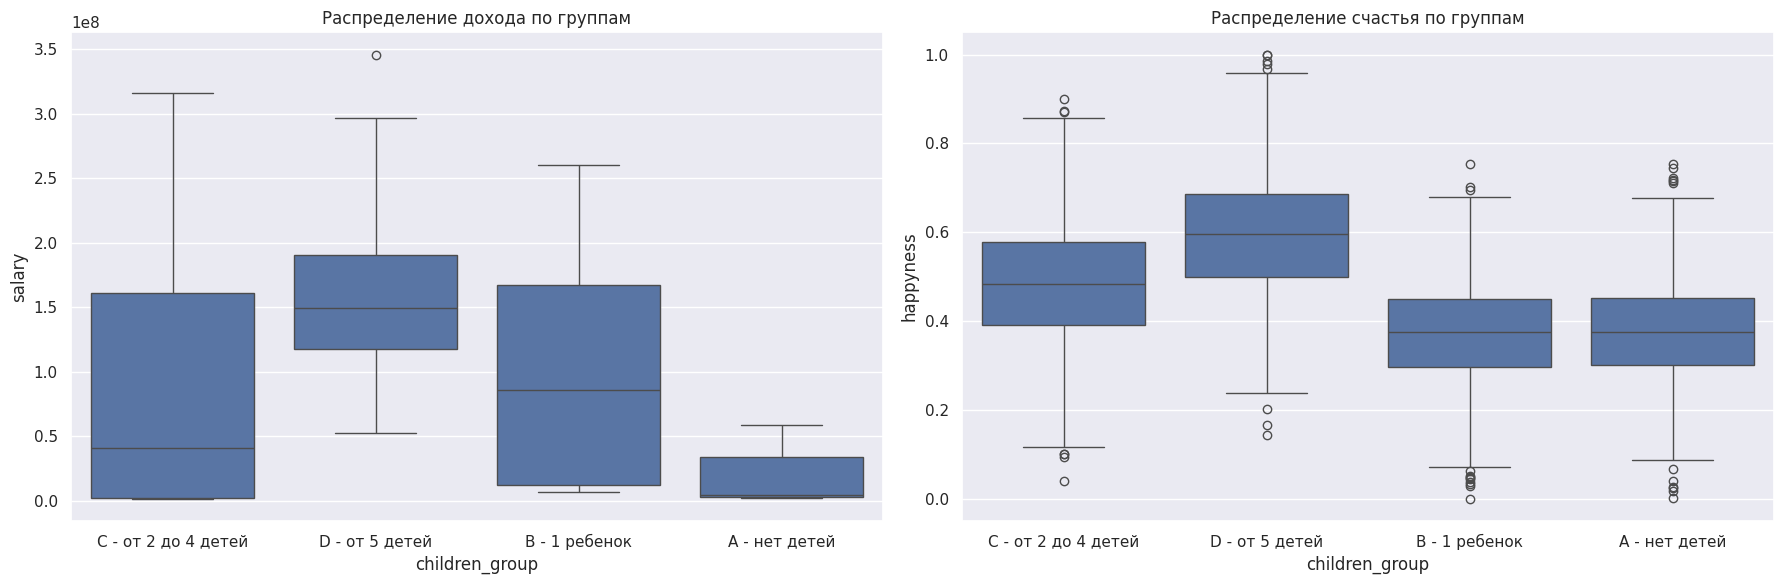

In [24]:
# Визуализация дохода и счастья по группам
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Визуализация дохода
sns.boxplot(x='children_group', y='salary', data=data, ax=axes[0])
axes[0].set_title('Распределение дохода по группам')

# Визуализация счастья
sns.boxplot(x='children_group', y='happyness', data=data, ax=axes[1])
axes[1].set_title('Распределение счастья по группам')
plt.tight_layout()
plt.show()

In [25]:
# Применение ANOVA для дохода
salary_groups = [data[data['children_group'] == group]['salary'] for group in groups]
f_statistic_salary, p_value_salary = f_oneway(*salary_groups)

print(f'F-статистика для дохода: {f_statistic_salary}')
print(f'p-значение для дохода: {p_value_salary}')

F-статистика для дохода: 1020.3162924766956
p-значение для дохода: 0.0


In [26]:
# Применение ANOVA для счастья
happyness_groups = [data[data['children_group'] == group]['happyness'] for group in groups]
f_statistic_happyness, p_value_happyness = f_oneway(*happyness_groups)

print(f'F-статистика для счастья: {f_statistic_happyness}')
print(f'p-значение для счастья: {p_value_happyness}')

F-статистика для счастья: 907.441460254017
p-значение для счастья: 0.0


In [27]:
# Интерпретация результатов
alpha = 0.05
print("\nРезультаты тестов:")
if p_value_salary < alpha:
    print("Доходы между группами статистически значимо различаются.")
else:
    print("Доходы между группами не отличаются статистически значимо.")

if p_value_happyness < alpha:
    print("Уровни счастья между группами статистически значимо различаются.")
else:
    print("Уровни счастья между группами не отличаются статистически значимо.")


Результаты тестов:
Доходы между группами статистически значимо различаются.
Уровни счастья между группами статистически значимо различаются.
